# сделать спектр треугольного сигнала

In [37]:
import scipy.integrate as integrate
from scipy.signal import find_peaks
import numpy as np

In [38]:
import matplotlib.pyplot as plt

In [39]:
class Fourie_series():
    
    _T_step_default = 100

    def __init__(self, x_t_func, T, w = None) -> None:
        self.X_t_func = x_t_func
        self.t_0 = 0 # ? 
        self.T = T # ?
        self.w = 2 * np.pi / self.T if w is None else w # ?

        self.a_s = []
        self.b_s = []

    def _calc_a_n(self, n):
        """
            Counts the values of a_n
            Calculates the integral using the scipy library. By QUADPACK method
        """
        twice_T = 2 / self.T

        under_integral_func = lambda t: self.X_t_func(t) * np.cos(n * self.w * t)

        integral = integrate.quad(under_integral_func, self.t_0, self.t_0 + self.T)[0]
        return twice_T * integral

    def _calc_b_n(self, n):
        """
            Counts the values of b_n
            Calculates the integral using the scipy library. By QUADPACK method
        """
        twice_T = 2 / self.T

        under_integral_func = lambda t: self.X_t_func(t) * np.sin(n * self.w * t)

        integral = integrate.quad(under_integral_func, self.t_0, self.t_0 + self.T)[0]

        return twice_T * integral
    
    def _calc_c_n(self, n):
        """
            Counts the values of c_n
            Calculates the integral using the scipy library. By QUADPACK method
        """
        freq = 1 / self.T

        under_integral_func = lambda t: self.X_t_func(t) * np.exp(-1j * n * self.w * t)

        integral = integrate.quad(under_integral_func, -self.T/2, self.T/2)[0]

        return freq * integral
    
    def _calc_fourie_series_legacy(self, t, N):
        a_0 = self._calc_a_n(0)

        twice_a_0 = a_0 / 2

        a_n = np.array([self._calc_a_n(n) * np.cos(n * self.w * t) for n in range(1, N)])
        b_n = np.array([self._calc_b_n(n) * np.sin(n * self.w * t) for n in range(1, N)])

        fourie_sum = a_n.sum() + b_n.sum()

        # self.a_s.append(a_n)
        # self.b_s.append(b_n)

        return twice_a_0 + fourie_sum
    
    def _calc_fourie_series(self, t, N):

        c_n_series = np.array([self._calc_c_n(n) * np.exp(1j * n * self.w * t) for n in range(-N, N)])

        return c_n_series.sum()
        
    def _calc_fouries_series_by_time(self, N, t_start = 0, t_end = None, t_step = None, use_legacy = False):
        if t_step is None and t_end is None and t_start < 2:
            t_end = 2
        if t_step is None:
            t_step = t_end / self._T_step_default

        time_series = np.arange(t_start, t_end, t_step)

        if use_legacy:
            fourie_series = np.array([self._calc_fourie_series_legacy(t, N) for t in time_series])
        else:
            fourie_series = np.array([self._calc_fourie_series(t, N) for t in time_series])

        return (fourie_series, time_series)

    def __call__(self, N, t_start = 0, t_end = None, t_step = None, use_legacy = False):
        return self._calc_fouries_series_by_time(N, t_start, t_end, t_step, use_legacy)


In [40]:
def calc_signal(s_func, t_start = 0, t_end = None, t_step = None):
    if t_end is None:
        t_end = 2
    if t_step is None:
        t_step = 0.01

    time_series = np.arange(t_start, t_end, t_step)
    signal_vals = np.array([s_func(t) for t in time_series])

    return signal_vals, time_series

In [41]:
def rec_imp(t):
    t_r = np.floor(t)
    if t_r % 2 == 0:
        return 2
    else:
        return 0

rec_ser = Fourie_series(rec_imp, 2)
rec_series = rec_ser(10, t_end=4.02, t_start=-4, t_step=0.01, use_legacy = True)
origin_signal = np.array([rec_imp(t) for t in rec_series[1]])

In [42]:
# S(t) = A * (1 - 2 * |f * (t - t0) - floor(0.5 + f * (t - t0))|)

def triang_imp(t):
    A = 2
    f = 2 # freq
    t0 = 0 # aka phase shift
    signal = A * (1-2 * np.abs(f * (t-t0) - np.floor(0.5 + f * (t-t0))))
    return signal

In [43]:
triang_signal, triang_signal_time_series = calc_signal(triang_imp)
spectrum_triang_signal = np.fft.fft(triang_signal)
restored_triang_signal = np.fft.ifft(spectrum_triang_signal)

d:\Programming\DigitalSignals\venv\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[]

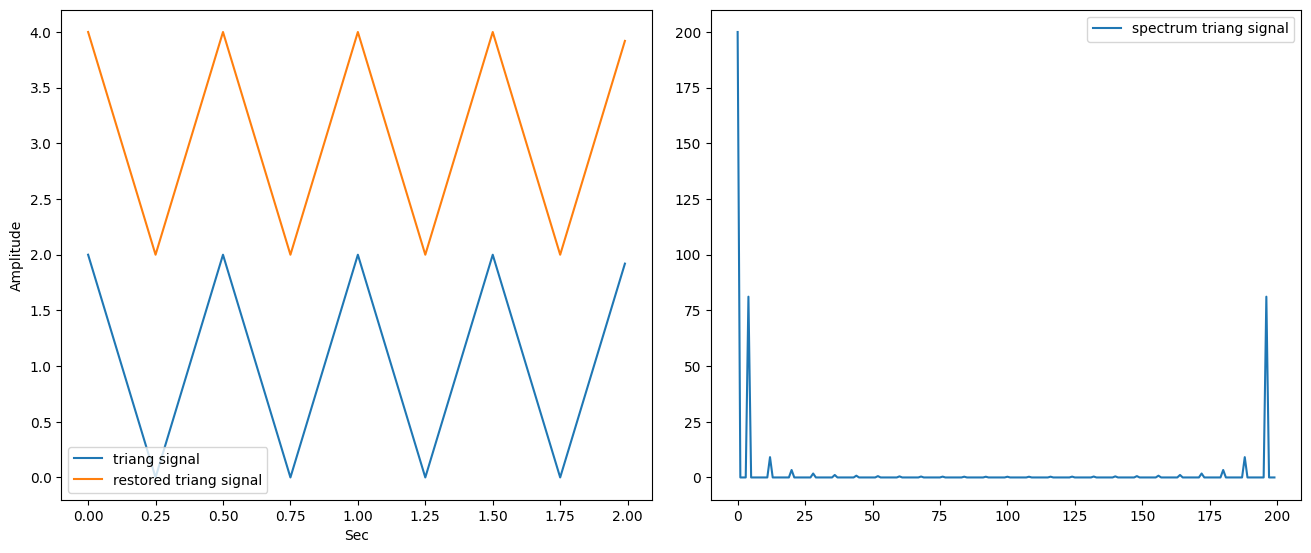

In [44]:
fig = plt.figure(figsize=(16, 14))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.subplot(221)
plt.plot(triang_signal_time_series, triang_signal, label="triang signal")
plt.plot(triang_signal_time_series, restored_triang_signal + 2, label="restored triang signal")
plt.legend()
plt.xlabel("Sec")
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(spectrum_triang_signal, label="spectrum triang signal")
plt.legend()
plt.plot()

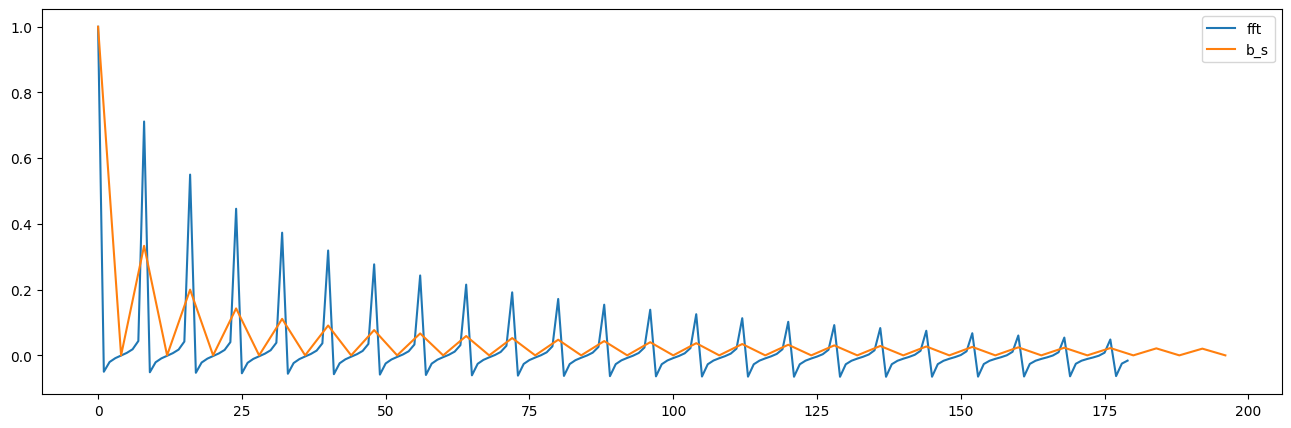

In [45]:
fig = plt.figure(figsize=(16, 5))
spectrum = np.fft.fft(origin_signal)[20:200]
b_s = np.array([rec_ser._calc_b_n(t) for t in range(1,51)])
plt.plot(spectrum/np.max(spectrum), label='fft')
plt.plot(np.arange(0, 200, 4), b_s/np.max(b_s), label='b_s')
plt.legend()
plt.show()

0.49875311720698257


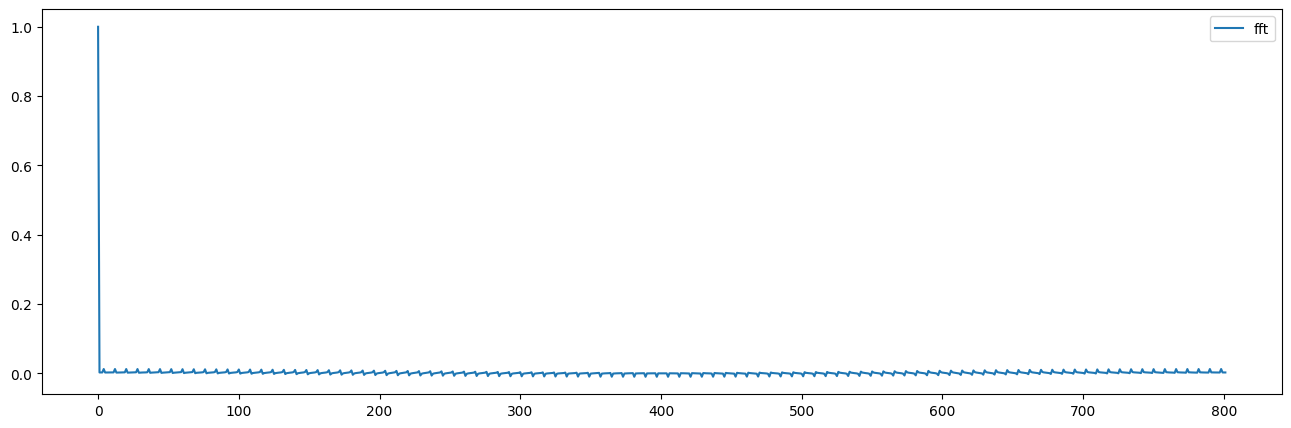

In [53]:
fig = plt.figure(figsize=(16, 5))
spectrum = np.fft.fft(origin_signal)
maximum = np.argmax(spectrum)
res = 1/0.01 / len(spectrum)
print((find_peaks(np.abs(spectrum))[0] * res)[0])


plt.plot(spectrum/np.max(spectrum), label='fft')
plt.legend()
plt.show()

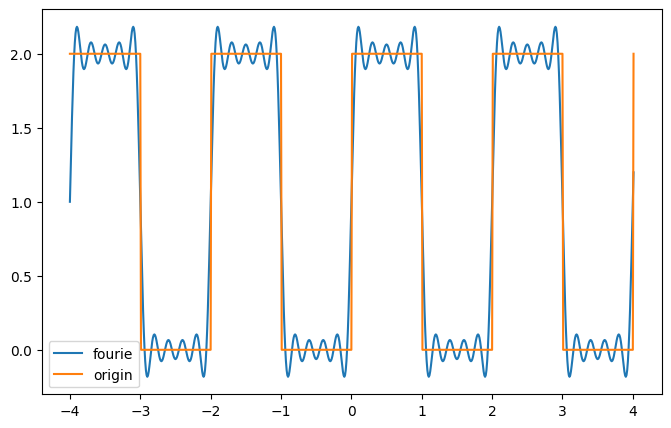

In [11]:
fig = plt.figure(figsize=(8, 5))
# print(rec_series)
plt.plot(rec_series[1], rec_series[0], label='fourie')
plt.plot(rec_series[1], origin_signal, label='origin')
plt.legend()
plt.show()

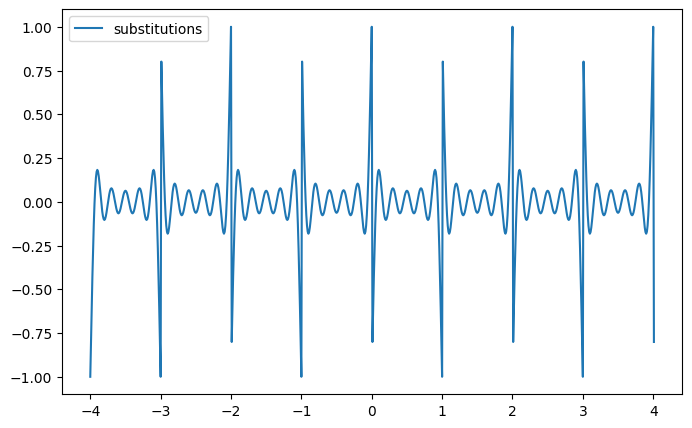

In [12]:
fig = plt.figure(figsize=(8, 5))
subs = rec_series[0] - origin_signal

plt.plot(rec_series[1], subs, label='substitutions')
plt.legend()
plt.show()

In [13]:
def cosinus_signal(w, A):
    return lambda t: np.cos(t * w) * A

w = 100 * 2 * 3.14

original_signal_func = cosinus_signal(w, 5)

cos_ser = Fourie_series(original_signal_func, T=1/100, w = w)
cos_series = cos_ser(10, t_end=0.3, t_start=0, t_step=0.001)

origin_signal_cos = np.array([original_signal_func(t) for t in cos_series[1]])

d:\Programming\DigitalSignals\venv\lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


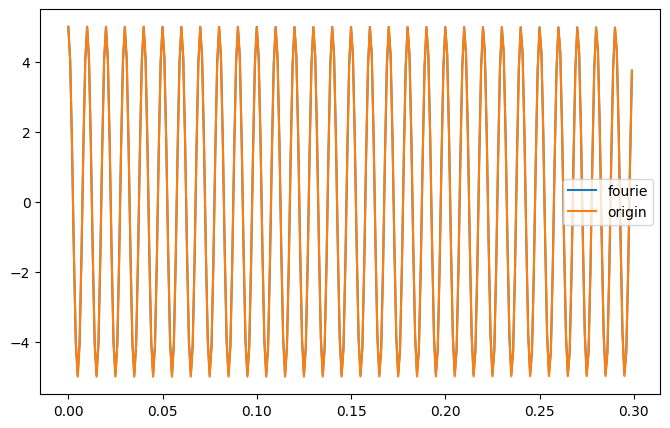

In [14]:
fig = plt.figure(figsize=(8, 5))
# print(cos_series[1])
plt.plot(cos_series[1], cos_series[0], label='fourie')
plt.plot(cos_series[1], origin_signal_cos, label='origin')
plt.legend()
plt.show()

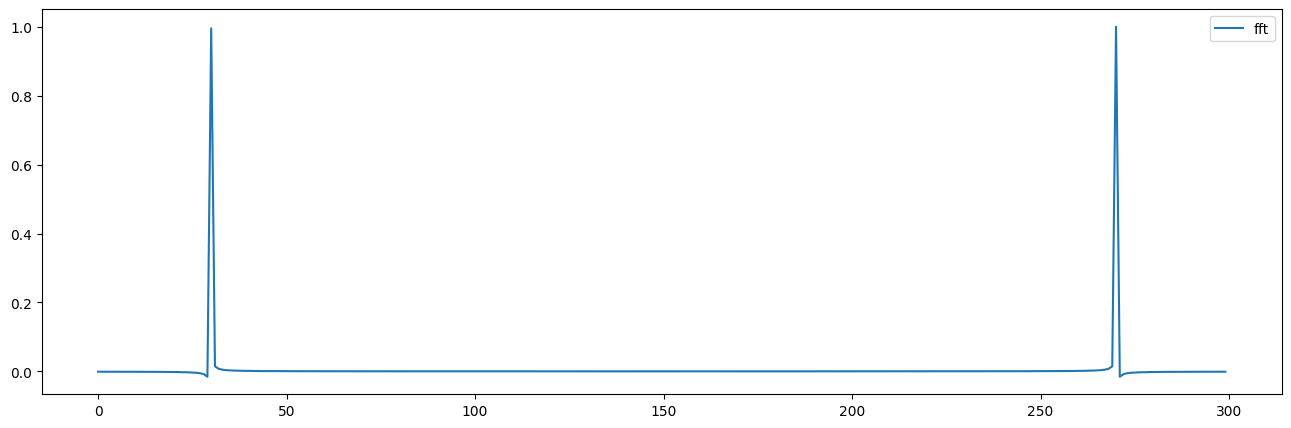

In [16]:
fig = plt.figure(figsize=(16, 5))
spectrum = np.fft.fft(origin_signal_cos)
plt.plot(spectrum/np.max(spectrum), label='fft')
plt.legend()
plt.show()

In [17]:
def Fourier_transform(origin_signal_cos):
    vals = origin_signal_cos
    N = vals.shape[0]
    k_s = np.arange(N)
    n_s = np.arange(N)
    series = []
    for k in k_s:
        series.append((vals[n_s] * np.exp(-2j * np.pi * k * n_s / N)).sum())
    
    return series

our_spectrum = Fourier_transform(origin_signal_cos)

In [18]:
noised_signal_cos = origin_signal_cos + np.random.random(origin_signal_cos.shape)

noised_spectrum = Fourier_transform(noised_signal_cos)

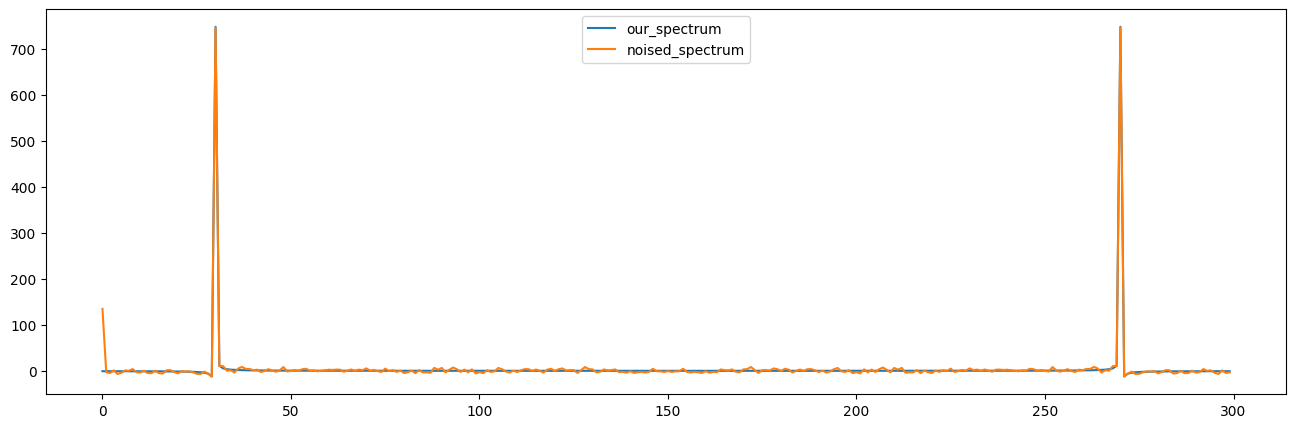

In [19]:
fig = plt.figure(figsize=(16, 5))
plt.plot(our_spectrum, label='our_spectrum')
plt.plot(noised_spectrum, label='noised_spectrum')
plt.legend()
plt.show()